# Introduction

The aim of this notebook is to present the main approaches I have adopted to address the data challenge of Qube hosted by the Collège de France.

The task is to predict the next returns from a stock market using a factor model. For a given stock, the factors are linear combinations of the past returns of this stock.

More precisely, let's $F$ be the number of factors, $N$ the number of stocks, $R_t$ the returns at day $t$ and $S_t$ the prediction of these returns. We are looking for *explicative factors* $F_{\ell, t}\in\mathbb{R}^N$, such that $$S_{t+1} := \sum_{\ell=1}^F \beta_\ell F_{t, \ell}\;,$$ with $\beta_1, \cdots, \beta_F \in \mathbb{R}$ and $\ell\in\{1, \cdots, F\}$.

The factors are linear combinations of the returns of the last $D$ days: $$F_{t,\ell}:=\sum_{k=1}^D A_{k,\ell} R_{t+1-k}\;,$$ with $A_\ell=\big(A_{k,\ell}\big)\in\mathbb{R}^D$ orthonormal, i.e. $\langle A_k, A_\ell \rangle=\delta_{k, \ell}$, for all $k,\ell$.

Here we have $N=50$, $F=10$ and $D=250$. 

We  have  three-year track record ($t=0\cdots753$) of 50 stocks and we have to provide $(A, \beta)$ as output. This output is then used to predict the returns of 50 other stocks over the same three-year period.

For returns $R_t$ and their predictions $S_t$, the prediction quality metric is as follow: $$Metric(A, \beta):=\frac{1}{504}\sum_{t=250}^{753}\frac{\langle S_t, R_t\rangle}{\lVert S_t\rVert\lVert R_t\rVert}$$
if $\lvert\langle A_i,Aj\rangle-\delta_{i,j}\rvert\le 10^{-6}$ for all $i,j$ and $Metric(A,\beta):=-1$ otherwise.

A difficulty of this study is the lack of an actual test set. A good practice in model training is to have three datasets: train, test and validation sets. The train set is used to train the parameters/weights of the studied models. We then try the trained models on the test set to estimate the variance-bias of the models, i.e. try to assess if we are overfitting or underfitting. This is a crucial feedback to select the models and their hyperparameters. Once we got a model with a satisfaying train score, we can run it on the validation set to validate it or not. It is important to use the validation dataset as less as possible to avoid overfitting the model to the available data. With the restriction of only two submissions per day, the hidden dataset, named *test dataset* by the data challenge description, has the role of the validation dataset here. Thus we have a train and a validation datasets, but no test dataset.

In the part *Models>Linear Regression Models>Train and test datasets*, I tried to constitute a test dataset by splitting the data provided. But this attempt is not conclusive.

In the following I will sometimes name the *public score* by the *validation score*.

I have tried four type of models:
* Models using well-known factors
* Models based on linear regression
* Neural networks
* Models using the correlation over time.

The **best model** I have found is a **combination of a Ridge linear regression and some well known factors**, which gives a train score of $0.1301$ and a public score of $0.0829$.

To participate to the challenge, I have used two accounts with pseudos *Line* and *Akina*.

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import pylab as pb
import pickle
from IPython.display import clear_output
from sklearn.linear_model import Ridge

In [3]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import regularizers
from tensorflow.keras import layers
import tensorflow as tf
import tensorflow_probability as tfp
import keras

In [4]:
from DataClass import DataClass
from Tools import *

# Data importation

In the following, I will use the classes *XYClass* and *DataClass*. *XYClass* provides DataFrame and array shapes of a given (x,y) dataset. *DataClass* get the data from the files *'X_train.csv'* and *'Y_train.csv'*. Moreover it can provide a train and a test datasets as XYClasses. The train and the test datasets are obtained by splitting the dataset randomly, "date-wise" or "stock-wise". For more details, see the class description or the section *Models>Linear Regression Models>Train and test datasets* of the present notebook.

In [5]:
data_class = DataClass(root="data/")
data_class.xy.x_df.head()

timeLag             1         2         3         4         5         6    \
date stocksID                                                               
250  0         0.000103  0.012387  0.011243  0.002595 -0.008509 -0.002711   
     1        -0.000982  0.003932  0.000050  0.001616 -0.003902 -0.001686   
     2         0.009301  0.003914  0.004995  0.001539  0.001452  0.002809   
     3         0.006515 -0.006553  0.009464  0.005204  0.004227 -0.005438   
     4        -0.006223  0.005415  0.014643  0.005195  0.004489  0.002695   

timeLag             7         8         9         10   ...       241  \
date stocksID                                          ...             
250  0         0.008934  0.006571 -0.018546 -0.008353  ...  0.009119   
     1         0.008810  0.001585 -0.000745 -0.002155  ...  0.001664   
     2         0.005177 -0.006942 -0.013340 -0.008071  ...  0.007416   
     3         0.008861  0.004025 -0.012432 -0.006100  ...  0.003807   
     4         0.007609  0.011437 -0.004804  0.039274  ...  0.014404   

timeLag             242       243       244       245       246       247  \
date stocksID                                                               
250  0        -0.008451  0.007120 -0.011745  0.009092 -0.005110 -0.016676   
     1        -0.002747  0.009994 -0.001293  0.012912 -0.004055 -0.006820   
     2         0.001600  0.007640 -0.000637 -0.001353 -0.009522 -0.003425   
     3        -0.010636  0.012446 -0.011980  0.002485 -0.017981 -0.010899   
     4        -0.005255 -0.008182 -0.004614  0.007082  0.007872 -0.003515   

timeLag             248       249       250  
date stocksID                                
250  0        -0.010776 -0.013002 -0.018647  
     1         0.012173 -0.022280 -0.008254  
     2        -0.006044 -0.013629 -0.008404  
     3        -0.008568 -0.006981 -0.022734  
     4        -0.007991 -0.008315 -0.024546  

[5 rows x 250 columns]

# Models

This section presents the different models I have tried. Note that for a given stock, a factor here is a linear combination of the past returns of this stock and do not depends of the other stocks. Thus it is not possible to integrate the correlation within stocks in the factors or even the market mean.

## Benchmark (brute force)

The data challenge provides a benchmark model, which is a "brute force" procedure. It generates orthonormal vectors $A_1,\ldots,A_{10}\in\mathbb R^{250}$ at random and then fits $\beta$ on the training data set by using linear regression, to repeat this operation many times, and finally to select the best result from these attempts.

This method gives a score of $0.0458$ on the train data set and of $0.0354$ on the validation dataset (public score). Thus my aim is to provide better models.

In [6]:
re_run = False

if re_run is False:
    output_fromCsv = pd.read_csv('submission_files/submission_benchmark_seed1234.csv', index_col=0, sep=',').to_numpy()
    A_QRT = output_fromCsv[:-10].reshape((250, 10))
    beta_QRT = output_fromCsv[-10:].reshape((10))
    
else:
    data_class = DataClass()

    Niter = 1000
    maxMetric = -1

    np.random.seed(1234)

    for iteration in range(Niter):

        # Generate a uniform random Stiefel matric A and fit beta with minimal mean square prediction error on the training data set

        A = random_mat_a()
        beta = fit_beta(data_class.xy, A)

        # compute the metric on the training set and keep the best result   

        m = metric(data_class.xy, A, beta)

        if m > maxMetric:
            print(iteration, 'metric_train:', m)

            maxMetric = m
            A_QRT = A
            beta_QRT = beta
    
    output = parameters_transform(A_QRT, beta_QRT)
    pd.DataFrame(output).to_csv('submission_files/submission_benchmark_seed1234.csv')

metric(data_class.xy, A_QRT, beta_QRT) # public metric: 0.03535

0.0457878219

## "Well-known" factors

I choose as a first step to try the well-known factors based on linear combinations of past returns:
* **$T_{mean}$-day mean returns factor** : $A_\ell$ will be $1/\sqrt{T_{mean}}$ on the $T_{mean}$ first rows, and 0 elsewhere;
* **Momentum factor** :  $A_\ell$ will be 0 on the $T_{momentum}$ first rows, and $1/\sqrt{250-T_{momentum}}$ elsewhere;
* **Exponential mean factor** :  $A_\ell$ will have exponential decaying values, i.e. $A_{k, \ell}=(1-\alpha)^k/\lvert A_\ell \rvert$, where $\alpha=\exp\big(-\ln(2)/h\big)\in(0, 1)$, with $h$ the half-life.
* **Acceleration factor** :  $A_\ell$ is alternatively filled by $1/\sqrt{250}$ and $-1/\sqrt{250}$, i.e. $A_{2q+1, \ell}=1/\sqrt{250}$ and $A_{2q, \ell}=-1/\sqrt{250}$ for all $q\in\{0, \cdots, 125\}$.
* **Auto-regression factors** : the auto-regression $A_\ell$ of degree $d$ is the vector $\delta_d=\big(\delta_{d,k}\big)_{k\in\{1, \cdots, 250\}}$.

The columns of $A$ will be orthonormalized using the Gram-schmidt method.

By selecting the best $(T_{mean}, T_{momentum}, h)$, the model using all the factors described above gives a train score of only $0.0376$.

It is even worse using the full auto-regression model ($A$ filled by the 10 first auto-regression vectors) with a train score of $0.024$.

Because of this bad scores, I did not submit the results of this two models.

### All factors

In [7]:
# model using all well-known factors

# if true, rerun the hyperparameter exploration
re_run = False

if re_run is False:
    well_known_factor_model_metrics = pd.read_csv('data/well_known_factor_model_metrics.csv').set_index(['day_mean_param', 'momentum_param', 'half_life'])
else:    

    data_class = DataClass()

    # set the range of the hyperparameters to explore
    day_mean_params = range(5, 25, 5)
    momentum_params = range(15, 100, 10)
    half_lifes = range(5, 100, 10)

    well_known_factor_model_metrics = []

    for T_mean in day_mean_params:
        for T_momentum in momentum_params:
            for half_life in half_lifes:

                A = np.zeros((250, 10))

                # 5-day mean returns factor
                A[:T_mean, 0] = 1/np.sqrt(T_mean)

                # Momentum factor
                A[T_momentum:, 1] = 1/np.sqrt(250-T_momentum)


                # Acceleration factor
                A[list(range(0, 250, 2)), 2] = 1/np.sqrt(250)
                A[list(range(1, 250, 2)), 2] = -1/np.sqrt(250)

                #First six auto-regression factors
                for i in range(6):
                    A[i, 3+i] = 1

                # Exponential mean factor
                alpha = np.exp(-np.log(2)/half_life)
                A[:, -1] = [(1-alpha)**n for n in range(250)]
                A[:, -1] /= np.sqrt(np.sum(A[:, -1]))

                # Orthonormalization of A
                A = gram_schmidt(A)

                # Fit beta
                beta = fit_beta(data_class.xy, A)

                #compute score
                well_known_factor_model_metrics.append((T_mean, T_momentum, half_life, metric(data_class.xy, A, beta)))

    well_known_factor_model_metrics = pd.DataFrame(np.array(well_known_factor_model_metrics), columns=['day_mean_param', 'momentum_param', 'half_life', 'score'])
    well_known_factor_model_metrics = well_known_factor_model_metrics.set_index(['day_mean_param', 'momentum_param', 'half_life'])
    well_known_factor_model_metrics.to_csv('data/well_known_factor_model_metrics.csv')

well_known_factor_model_metrics.sort_values('score', ascending=False).head(5)

score
day_mean_param momentum_param half_life          
5.0            35.0           95.0       0.037959
                              85.0       0.037957
                              75.0       0.037955
                              65.0       0.037952
                              55.0       0.037947

### Auto-regression model

In [8]:
# Pure auto-regression model : first 10 auto-regression vectors

data_class = DataClass()

A = np.zeros((250, 10))

#Auto-regression factors
for i in range(10):
    A[i, i] = 1
    
# Fit beta
beta = fit_beta(data_class.xy, A)

#compute score
metric(data_class.xy, A, beta)

0.0240279909

## Linear regression models

### Simple Linear regression

The second idea is to use the regression linear. We fit $\gamma$ to minimize $\lVert Y - X\gamma\lVert$. Then we choose $A$ and $\beta$ such that $\gamma = A\beta$.

More precisely, the 25 first rows of the first column of $A$ are equal to the 25 first values of $\gamma$ divided by $c$, the norm of the 25 first values of $\gamma$. The first value of beta is equal to $c$.
The other columns are filled the same way.

This gives a score on the training dataset of $0.133$, which is far above the benchmark score. The public score of this model is $0.0819$, which is a great improvment compare to the benchmark public score (on Line account, date *22/06*, Method *Linear Regression* and Parameters *None*).

In [9]:
# Simple linear regression

data_class = DataClass()

x_tab = data_class.xy.x_tab
y_tab = data_class.xy.y_tab

gamma_lr = (np.linalg.inv(x_tab.T@x_tab)@x_tab.T)@y_tab

A = np.zeros((250, 10))
beta = np.zeros(10)
for i in range(10):
    g = gamma_lr[i*25:(i+1)*25]
    c = np.sqrt(np.sum(g**2))
    A[i*25:(i+1)*25, i] = gamma_lr[i*25:(i+1)*25]/c
    beta[i] = c    

print(metric(data_class.xy, A, beta))

output = parameters_transform(A, beta)
pd.DataFrame(output).to_csv('submission_files/submission_simple_linear_regression.csv')

0.1331904539


### Increase Bias

A way to improve the public score might be to reduce the overfitting i.e. increase the bias. There are several ways to do it. Here I tried two methods: Ridge and an ensemble method. These methods should decrease the training score, but increase the validation score (public measure).

#### Ridge

The Ridge linear regression consists of penalizing the minimalization of $\lVert Y-X\gamma \rVert$ by adding the term $\alpha \lVert \gamma\rVert$.

With $\alpha=1000$, we get a train score of $0.1298$ and a validation score of $0.0823$, which is slightly better than the simple linear regression score (on Akina account, date *27/06*, Method *Ridge* and Parameters *alpha=1000*).
 
I choose $\alpha$ more or less as the smallest alpha for which the train score stop decreasing (see figure below representing the train score as a function of $\alpha$).

In [10]:
# Ridge with alpha = 1000

data_class = DataClass()

x_tab = data_class.xy.x_tab
y_tab = data_class.xy.y_tab

model = Ridge(alpha=1000, fit_intercept=False).fit(x_tab, y_tab)

gamma_ridge = model.coef_

A = np.zeros((250, 10))
beta = np.zeros(10)
for i in range(10):
    g = gamma_ridge[i*25:(i+1)*25]
    c = np.sqrt(np.sum(g**2))
    A[i*25:(i+1)*25, i] = gamma_ridge[i*25:(i+1)*25]/c
    beta[i] = c    

print(metric(data_class.xy, A, beta))

output = parameters_transform(A, beta)
pd.DataFrame(output).to_csv('submission_files/submission_ridge_alpha1000.csv')

0.1298448921


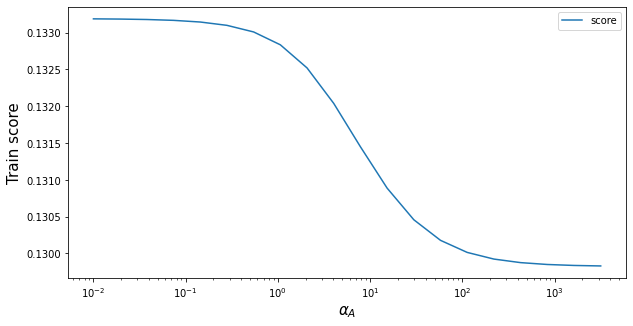

In [11]:
# Figure plotting train score as a function of the parameter alpha of the Ridge linear regression
res = []
data_class = DataClass()

x_tab = data_class.xy.x_tab
y_tab = data_class.xy.y_tab

for alpha in np.logspace(-2, 3.5, num=20, endpoint=True):
    model = Ridge(alpha=alpha, fit_intercept=False).fit(x_tab, y_tab)

    gamma_ridge = model.coef_

    A = np.zeros((250, 10))
    beta = np.zeros(10)
    for i in range(10):
        g = gamma_ridge[i*25:(i+1)*25]
        c = np.sqrt(np.sum(g**2))
        A[i*25:(i+1)*25, i] = gamma_ridge[i*25:(i+1)*25]/c
        beta[i] = c    

    res.append((alpha, metric(data_class.xy, A, beta)))
ax = pd.DataFrame(res, columns=['alpha', 'score']).set_index('alpha').plot(figsize=(10, 5), logx=True);
ax.set_xlabel(r'$\alpha_A$', fontsize=15);
ax.set_ylabel('Train score', fontsize=15);

Another way to increase the bias might be to not use the exact $\beta$ to reproduce perfectly $\gamma$, but to fit $\beta$ using Ridge.

Let $\alpha_A$ be the Ridge parameter to fit $A$ and  $\alpha_\beta$ be the Ridge parameter to fit $\beta$.

$\alpha_\beta$ is chosen as $\alpha_A$ (see figure below representing the train score as a function of $\alpha_\beta$ with $\alpha_A=1000$).

With $\alpha_A=1000$ and $\alpha_{\beta}=1000$, the **train score** ($0.1298$) and the *validation score* ($0.08229$) do not change. Thus it looks like adding Ridge on $\beta$ fitting do not bring any improvment.

In [12]:
# Ridge with alpha=1000 for A and with alpha=100 for beta
alpha_A = 1000
alpha_beta = 1000

data_class = DataClass()

x_tab = data_class.xy.x_tab
y_tab = data_class.xy.y_tab

model = Ridge(alpha=alpha_A, fit_intercept=False).fit(x_tab, y_tab)

gamma_ridge = model.coef_

A = np.zeros((250, 10))
beta = np.zeros(10)
for i in range(10):
    g = gamma_ridge[i*25:(i+1)*25]
    c = np.sqrt(np.sum(g**2))
    A[i*25:(i+1)*25, i] = gamma_ridge[i*25:(i+1)*25]/c

beta = fit_beta_ridge(data_class.xy, A, alpha=alpha_beta)    

print(metric(data_class.xy, A, beta))

output = parameters_transform(A, beta)
pd.DataFrame(output).to_csv('submission_files/submission_A_ridge1000_beta_ridge1000.csv')

0.1298448921


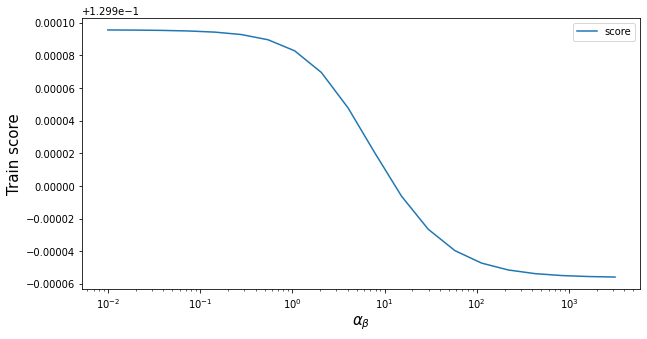

In [13]:
# Figure plotting train score as a function of the parameter alpha of the Ridge linear regression
alpha_A = 1000

res = []
data_class = DataClass()

x_tab = data_class.xy.x_tab
y_tab = data_class.xy.y_tab

for alpha_beta in np.logspace(-2, 3.5, num=20, endpoint=True):
    model = Ridge(alpha=alpha_A, fit_intercept=False).fit(x_tab, y_tab)

    gamma_ridge = model.coef_

    A = np.zeros((250, 10))
    beta = np.zeros(10)
    for i in range(10):
        g = gamma_ridge[i*25:(i+1)*25]
        c = np.sqrt(np.sum(g**2))
        A[i*25:(i+1)*25, i] = gamma_ridge[i*25:(i+1)*25]/c    
    
    beta = fit_beta_ridge(data_class.xy, A, alpha=alpha_beta)    

    res.append((alpha_beta, metric(data_class.xy, A, beta)))    

ax = pd.DataFrame(res, columns=['alpha', 'score']).set_index('alpha').plot(figsize=(10, 5), logx=True);
ax.set_xlabel(r'$\alpha_\beta$', fontsize=15);
ax.set_ylabel('Train score', fontsize=15);

#### Train and test datasets

I tried to build train and test datasets by splitting the data provided. I have tested 3 types of split:
* **pure random split**: the data (X, Y) is shuffled and then split in two. This arbitrary split might be unsatisfying, since it "breaks" the structure of the data, i.e. does not take into account the fact that there are time series from the same stocks.
* **"date-wise" split**: the dates are shuffled and split in two. This split insures that for a given date, all the 50 stocks are in the same dataset. But this split, as the random split, does not provide two independant train and test datasets since X is built with shifted time series.
* **"stock-wise" split**: the stocks are shuffled and split in two. This split insures that train and test datasets do not contain the same shifted time series. This split provides a setup close to the challenge setup, but with 25stocks instead of 50.

In the previous part, a Ridge with $\alpha=1000$ has proved to have a higher bias than the simple linear regression. Thus I have trained the linear model and the ridge model on train and test datasets split as described above. If these methods creating train and test models work, I am expecting to observe the decrease of the variance, i.e. the train score of Ridge($\alpha$=0) model must be lower than the one of Ridge($\alpha$=1000) model, but the test scores should display the contrary.

To check this, I have computed the train and test score 1000 times for the 6 cases (2 models x 3 splits).
The first following figure is the histograms of the train score (left column) and the test score (right column) for Ridge($\alpha=0$) model (in blue) and Ridge($\alpha=1000$) model (in orange) for the random (first row), date-wise (middle row) and stock-wise (last row) split methods.
The second following figure shows the histograms of the difference between the train scores (left column) and the test scores (right column) of the two models for the random (first row), date-wise (middle row) and stock-wise (last row) split methods.

We can see that as expected the train score with Ridge($\alpha=0$) is above the train score with Ridge($\alpha=1000$). But for the random and date-wise split methods, the test score of Ridge($\alpha=1000$) is above the test score of Ridge($\alpha=0$) in only around 2/3 of the cases. It is around 1/2 for the stock-wise method.

Thus this split methods do not look to provide good train and test datasets to assess the variance and bias of a model.

In [14]:
# Ridge with alpha=1000 for A

re_run = False
if re_run is False:
    train_test_score_df = pd.read_csv('data/test_train_split_try.csv')
    train_test_score_df = train_test_score_df.set_index(['alpha', 'split_method']).sort_index()
else:

    train_test_score_df = []
    for split_method in ['random', 'stock', 'date']:
        for ii in range(1000):
            data_class = DataClass(prop_train=0.5, split_method=split_method)

            x_tab = data_class.xy_train.x_tab
            y_tab = data_class.xy_train.y_tab
            
            for alpha_A in [0, 1000]:

                print(split_method, alpha_A, ii)


                model = Ridge(alpha=alpha_A, fit_intercept=False).fit(x_tab, y_tab)

                gamma_ridge = model.coef_

                A = np.zeros((250, 10))
                beta = np.zeros(10)
                for i in range(10):
                    g = gamma_ridge[i*25:(i+1)*25]
                    c = np.sqrt(np.sum(g**2))
                    A[i*25:(i+1)*25, i] = gamma_ridge[i*25:(i+1)*25]/c

                beta = fit_beta(data_class.xy, A)    

                score_train = metric(data_class.xy_train, A, beta)
                score_test = metric(data_class.xy_test, A, beta)
                train_test_score_df.append((split_method, alpha_A, score_train, score_test))
                clear_output()
    train_test_score_df = pd.DataFrame(train_test_score_df, columns=['split_method', 'alpha', 'score_train', 'score_test'])
    train_test_score_df.to_csv('data/test_train_split_try.csv', index=False)
    train_test_score_df = train_test_score_df.set_index(['alpha', 'split_method']).sort_index()



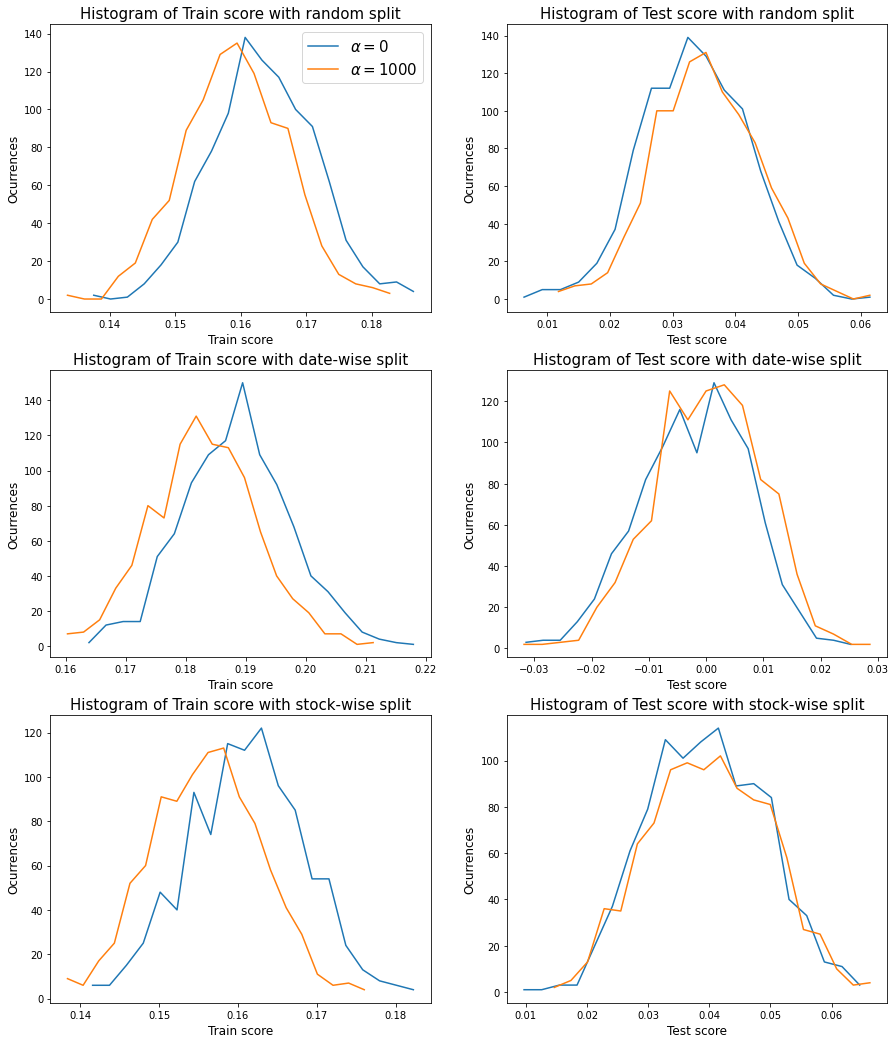

In [15]:
split_labels = ['random', 'date-wise', 'stock-wise']

fig, ax = pb.subplots(ncols=2, nrows=3, figsize=(15, 18))
for i, split_name in enumerate(['random', 'date', 'stock']):
    for j, alpha in enumerate([0, 1000]):

        df_temp = train_test_score_df.loc[(alpha, split_name), 'score_train']
        y, x = np.histogram(df_temp, bins=20)
        ax[i, 0].plot(x[1:], y, label=r'$\alpha=$'+str(alpha))
        ax[i, 0].set_xlabel('Train score', fontsize=12)  
        ax[i, 0].set_ylabel('Ocurrences', fontsize=12) 
        ax[i, 0].set_title('Histogram of Train score with %s split' % split_labels[i], fontsize=15)

        df_temp = train_test_score_df.loc[(alpha, split_name), 'score_test']
        y, x = np.histogram(df_temp, bins=20)
        ax[i, 1].plot(x[1:], y, label=r'$\alpha=$'+str(alpha))
        ax[i, 1].set_xlabel('Test score', fontsize=12) 
        ax[i, 1].set_ylabel('Ocurrences', fontsize=12) 
        ax[i, 1].set_title('Histogram of Test score with %s split' % split_labels[i], fontsize=15)
    
ax[0, 0].legend(fontsize=15);

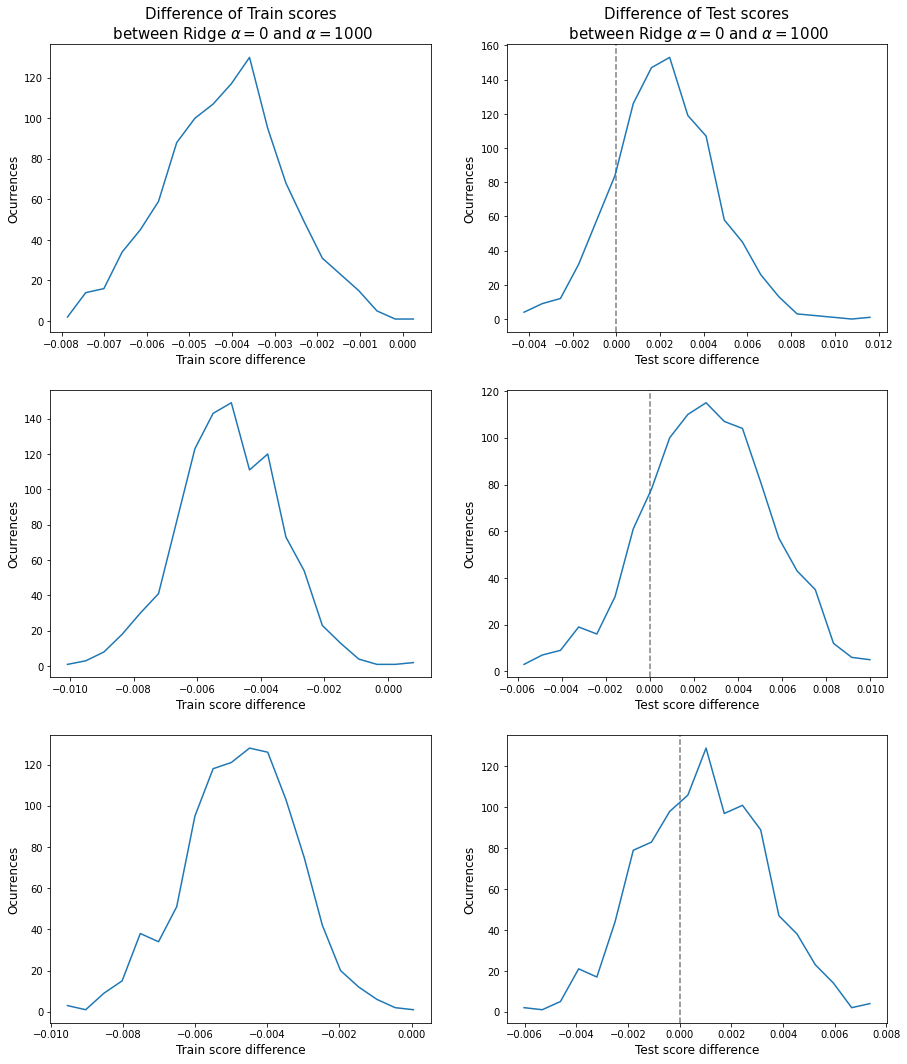

In [16]:
fig, ax = pb.subplots(ncols=2, nrows=3, figsize=(15, 18))
for i, split_name in enumerate(['random', 'date', 'stock']):
        
    ax[i, 0].set_xlabel('Train score difference', fontsize=12)
    ax[i, 1].set_xlabel('Test score difference', fontsize=12)
    
    ax[i, 1].axvline(0, ls='--', c='grey')
    
    for j, score_type in enumerate(['score_train', 'score_test']):

        val0 = train_test_score_df.loc[(0, split_name), score_type].values
        val1000 = train_test_score_df.loc[(1000, split_name), score_type].values
        
        y, x = np.histogram(val1000-val0, bins=20)
        ax[i, j].plot(x[1:], y)
        ax[i, j].set_ylabel('Ocurrences', fontsize=12) 
        
ax[0, 0].set_title('Difference of Train scores\n between Ridge'+r' $\alpha=0$ and $\alpha=1000$', fontsize=15)
ax[0, 1].set_title('Difference of Test scores\n between Ridge'+r' $\alpha=0$ and $\alpha=1000$', fontsize=15);

#### Ensemble method

This method consists of splitting the dataset in $n$ datasets and fit $\gamma_1, \cdots, \gamma_n\in\mathbb R^{250}$ on each of these $n$ datasets. The $\gamma$ is the mean of the gammas, i.e. $\gamma=(\gamma_1+ \cdots+ \gamma_n)/n$ .

I have split the dataset in 25 parts (each containing two stocks). The training score is around $0.105$ and the validation score is $0.0665$, which is better than the benchmark score, but much lower than the Ridge linear regression score (on Line account, date *27/06*, Method *Linear Regression* and Parameters *Ensemble bias, 25 subsets "stock-wise" split*).


In [17]:
data_class = DataClass(prop_train=1, nb_train_set=25, split_method='stock')
gamma = np.zeros(250)

for i in range(data_class.nb_train_set):
    x_tab = data_class.xy_train[i].x_tab
    y_tab = data_class.xy_train[i].y_tab

    gamma += (np.linalg.inv(x_tab.T@x_tab)@x_tab.T)@y_tab

gamma /= data_class.nb_train_set

A = np.zeros((250, 10))
beta = np.zeros(10)
for i in range(10):
    g = gamma[i*25:(i+1)*25]
    c = np.sqrt(np.sum(g**2))
    A[i*25:(i+1)*25, i] = gamma[i*25:(i+1)*25]/c

beta = fit_beta(data_class.xy, A)

print(metric(data_class.xy, A, beta))

output = parameters_transform(A, beta)
pd.DataFrame(output).to_csv('submission_files/submission_linear_regression_ensemble_bias_25sets.csv')

0.10551371


### Ridge linear regression combine with well-known factors

Here I have combined linear regression with well-known factors. To do that I have set the first column of $A$ as $\gamma/\lVert \gamma \rVert$ and fill the rest with the factors described in the part *"Well-known" factors* (here there are only the 5 first auto-regression factors). I orthonormalize $A$ using Gram-Schmidt. Finally I fit the $\beta$.
The parameters $T_{mean}$, $T_{momentum}$ and $h$ are chosen as maximising the train score in the model using all the "well-known" factors.

The **train score** $0.1301$ is slightly better than the one of the pure ridge model and the **public score** is also better with a value of $0.0829$ (on Line account, date *28/06*, Method *Ridge + well-known factors* and Parameters *alpha=1000*).

Here I see two ways to maybe improve the public score. First by exploring the hyperparameters like I did in section *Models>"Well-known" factors>All factors"*. Second think about other explicit factors based on macro-economic knowledge to replace one or several of the well-known factors.

In [18]:
# Get best parameters for the "well-know" factor model
T_mean, T_momentum, half_life = np.array(well_known_factor_model_metrics.sort_values('score').index[-1]).astype(int)
alpha_A = 1000

# get X and Y
data_class = DataClass()
x_tab = data_class.xy.x_tab
y_tab = data_class.xy.y_tab

# Filling A
A = np.zeros((250, 10))

# Factor from linear regression
model = Ridge(alpha=alpha_A, fit_intercept=False).fit(x_tab, y_tab)
gamma = model.coef_
A[:, 0] = gamma/np.sqrt(np.sum(gamma**2))

# 5-day mean returns factor
A[:T_mean, 1] = 1/np.sqrt(T_mean)

# Momentum factor
A[T_momentum:, 2] = 1/np.sqrt(250-T_momentum)

# Acceleration factor
A[list(range(0, 250, 2)), 3] = 1/np.sqrt(250)
A[list(range(1, 250, 2)), 3] = -1/np.sqrt(250)

#Auto-regression factors
for i in range(5):
    A[i, 4+i] = 1

# Exponential mean factor
a = np.exp(-np.log(2)/half_life)
A[:, 9] = [(1-a)**n for n in range(250)]
A[:, 9] /= np.sqrt(np.sum(A[:, -1]))

# Orthonormalization of A
A = gram_schmidt(A)

# Fit beta
beta = fit_beta(data_class.xy, A)

print('train metric:', metric(data_class.xy, A, beta))

output = parameters_transform(A, beta)
pd.DataFrame(output).to_csv('submission_files/submission_ridge1000_with_well_know_factors.csv')

train metric: 0.1301419917


## Neural network

We can notice, that the formula $S_{t+1}= \sum_{\ell=1}^F \beta_\ell \sum_{k=1}^D A_{k,\ell} R_{t+1-k}\;,$ is exactly the formula of a neural network with a hidden layer of size 10 without activation functions or bias (intercept). The weights of the hidden layer are the values of $A$ and the weights of the output layer are the values of $\beta$. See the diagram below. I add to the hidden layer a constraint of orthonormality.

![Diagram](NN_diagram.png)

### Usual Hyperparameters

A first trial with default *batch_size* and *epochs* gives a nice score: **train score** around $0.13$ and **validation score** around $0.0812$ (on Line account, date *20/06*, Method *Neural network* and Parameters *(batch_size, epochs)=(32, 100)*).

Note that the model exploration has a lot of variance. Retraining the neural network (even with the same hyperparameters) gives different train and validation scores even if it stays around the same values. See:
* (on Line account, date *20/06*, Method *Neural network* and Parameters *(batch_size, epochs)=(10, 100)*), public score $0.0766$;
* (on Line account, date *21/06*, Method *Neural network* and Parameters *(batch_size, epochs, optimizer)=(200, 500, RMSprop)*), public score $0.08$.

In [19]:
re_run = False

if re_run is False:
    output = pd.read_csv('submission_files/submission_NN_batch_size32_epochs100.csv', index_col=0, sep=',').to_numpy()
    A = output[:-10].reshape((250, 10))
    beta = output[-10:].reshape((10))

else:


    data_class = DataClass()
    x_tab = data_class.xy.x_tab
    y_tab = data_class.xy.y_tab

    model = keras.Sequential()
    model.add(keras.Input(shape=(250,)))

    # Hidden layer of size 10, its weights are A. The kernel has a orthonormality constraint
    model.add(layers.Dense(10, activation=None, use_bias=False, kernel_constraint=OrthonormalityKernelConstraint()))

    # output layer, its weights are beta
    model.add(layers.Dense(1, activation=None, use_bias=False))

    # compile with the least square loss function and the default optimizer (Adam)
    model.compile(loss='mean_squared_error', optimizer='Adam')

    # fit with the default hyperparameters (batch_size, epochs)=(32, 100)
    model.fit(x_tab, y_tab, epochs=100, verbose=0)

    # get A and beta, which are the layer weights
    A = model.layers[0].get_weights()[0]
    beta = model.layers[1].get_weights()[0]

    output = parameters_transform(A, beta)
    pd.DataFrame(output).to_csv('submission_files/submission_NN_batch_size32_epochs100.csv')

metric(data_class.xy, A, beta)

0.1281015658

### Exploring Hyperparameters

The following code explore the hyperparameters of the neural network: batch_size, epochs and optimizer. Globally the *RMSprop* optimizer gives better train scores than the *Adam* optimizer. Moreover it seems that it is better to have batches of size above 250 and more than 300 epochs.

With (batch_size, epochs, optimizer)=(500, 500, RMSprop), I got a **train score** of $0.134$ and a **public score** of $0.0829$, which is as good as the the combination of Ridge with well-known factors (on Akina account, date *28/06*, Method *Neural network* and Parameters *(batch_size, epochs, optimizer)=(500, 500, RMSprop)*). However the latter is better, because less sophisticated and with a smaller variance.

Testing a lot outcomes of the neural network would give a better public score. But such approach is not relevant, because it will overfit the $A$ and $\beta$ on the validation test and might not gives good performance on a third dataset.

In [20]:
# If true, Re-compute everything
init = False

data_class = DataClass()
x_tab = data_class.xy.x_tab
y_tab = data_class.xy.y_tab

if init is True:
    A_beta_dict = dict()
    metric_train_list = []    
    with open('data/NN_exploration.pickle', 'wb') as f1:
        pickle.dump((A_beta_dict, metric_train_list), f1)
else:
    with open('data/NN_exploration.pickle', 'rb') as f:
        A_beta_dict, metric_train_list = pickle.load(f)

metric_train_df = pd.DataFrame(metric_train_list, columns=['batch_size', 'epochs', 'optimizer', 'score']).set_index(['batch_size', 'epochs', 'optimizer'])
        
max_m = 0
max_para = None

batch_size_list = list(range(50, 251, 50))+[500, 5000]
epochs_list = [10, 100, 300, 500]
optimizers = ['Adam', 'RMSprop']

for batch_size in batch_size_list:
    for epochs in epochs_list:
        for optimizer in optimizers:
            print(batch_size, epochs, optimizer)
            if (batch_size, epochs, optimizer) not in A_beta_dict:

                model = keras.Sequential()
                model.add(keras.Input(shape=(250,)))

                # Hidden layer of size 10, its weights are A. The kernel has a orthonormality constraint
                model.add(layers.Dense(10, activation="linear", use_bias=False, kernel_constraint=OrthonormalityKernelConstraint()))

                # output layer, its weights are beta
                model.add(layers.Dense(1, activation="linear", use_bias=False))

                model.compile(loss='mean_squared_error', optimizer=optimizer)
                model.fit(x_tab, y_tab, batch_size=batch_size, epochs=epochs, verbose=0)

                A = model.layers[0].get_weights()[0]
                beta = model.layers[1].get_weights()[0]                
                m = metric(data_class.xy, A, beta)

                A_beta_dict[(batch_size, epochs, optimizer)] = [A, beta]
                metric_train_list.append([batch_size, epochs, optimizer, m])


                with open('data/NN_exploration.pickle', 'wb') as f1:
                    pickle.dump((A_beta_dict, metric_train_list), f1)
                    
                if m > max_m:
                    max_m = m
                    max_para = (batch_size, epochs, optimizer)
                    clear_output()
                    print(max_para, max_m)
clear_output()
metric_train_df = pd.DataFrame(metric_train_list, columns=['batch_size', 'epochs', 'optimizer', 'score']).set_index(['batch_size', 'epochs', 'optimizer'])
display(metric_train_df.sort_values('score', ascending=False).head(5))

batch_size, epochs, optimizer = np.array(metric_train_df.sort_values('score').index[-1])
A, beta = A_beta_dict[(int(batch_size), int(epochs), optimizer)]
output = parameters_transform(A, beta)
pd.DataFrame(output).to_csv('submission_files/submission_NN_best_hyperparameters.csv')

score
batch_size epochs optimizer          
500        500    RMSprop    0.133657
250        300    Adam       0.133419
200        300    Adam       0.133343
                  RMSprop    0.133276
500        300    RMSprop    0.133252

### Decreasing variance

I tried to decrease the variance by using the l2-regulizer, which is similare to the Ridge penalization in linear regression. I apply the regularization on the hidden layer and not the output layer, since applying Ridge of the beta fitting did not improve scores (see section *Models>Linear regression models>Increase Bias> Ridge*).

I have arbitrary chosen $\alpha=3.5^{-6}$ the regularisation parameter giving a **train score** around $0.095$ (see figure below representing the train score as a function of $\alpha$). With this model, the public score is $0.08$. Thus this model is the one with the lower variance so far (on Line account, date *28/06*, Method *Neural network l2-regularized* and Parameters *(batch_size, epochs, optimizer, alpha)=(500, 500, RMSprop, 3.5e-6)*).

We might get a better public score with a lower $\alpha$.

In [21]:
re_run = False

if re_run is False:
    output = pd.read_csv('submission_files/submission_NN_regulirazed.csv', index_col=0, sep=',').to_numpy()
    A = output[:-10].reshape((250, 10))
    beta = output[-10:].reshape((10))
else:

    batch_size, epochs, optimizer = metric_train_df.sort_values('score').index[-1]

    data_class = DataClass()
    x_tab = data_class.xy.x_tab
    y_tab = data_class.xy.y_tab

    model = keras.Sequential()
    model.add(keras.Input(shape=(250,)))

    # Hidden layer of size 10, its weights are A. The kernel has a orthonormality constraint
    model.add(
        layers.Dense(
            10, activation=None, use_bias=False, kernel_constraint=OrthonormalityKernelConstraint(),
            kernel_regularizer=regularizers.l2(3.5e-6))
    )

    # output layer, its weights are beta
    model.add(
        layers.Dense(1, activation=None, use_bias=False))

    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.fit(x_tab, y_tab, batch_size=batch_size, epochs=epochs, verbose=0)

    A = model.layers[0].get_weights()[0]
    beta = model.layers[1].get_weights()[0]

    output = parameters_transform(A, beta)
    pd.DataFrame(output).to_csv('submission_files/submission_NN_regulirazed.csv')
    
print(metric(data_class.xy, A, beta))

0.0956905843


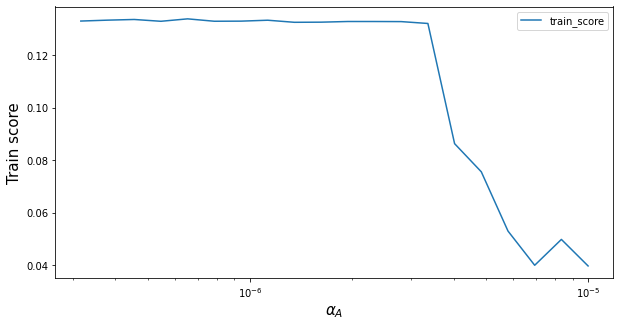

In [22]:
re_run = False

if re_run is False:
    nn_l2_regularisation = pd.read_csv('data/NN_l2_regularisation.csv').set_index('alpha')
else:

    batch_size, epochs, optimizer = metric_train_df.sort_values('score').index[-1]
    nn_l2_regularisation = []

    data_class = DataClass()
    x_tab = data_class.xy.x_tab
    y_tab = data_class.xy.y_tab

    for alpha in np.logspace(-7, -3, num=20, endpoint=True):
        model = keras.Sequential()
        model.add(keras.Input(shape=(250,)))

        model.add(
            layers.Dense(
                10, activation=None, use_bias=False, kernel_constraint=OrthonormalityKernelConstraint(),
                kernel_regularizer=regularizers.l2(alpha))
        )

        # output layer, its weights are beta
        model.add(
            layers.Dense(1, activation=None, use_bias=False))

        model.compile(loss='mean_squared_error', optimizer=optimizer)
        model.fit(x_tab, y_tab, batch_size=500, epochs=250, verbose=0)

        A = model.layers[0].get_weights()[0]
        beta = model.layers[1].get_weights()[0]

        nn_l2_regularisation.append((alpha, metric(data_class.xy, A, beta)))
        print(nn_l2_regularisation[-1])
    nn_l2_regularisation = pd.DataFrame(nn_l2_regularisation, columns=['alpha', 'train_score']).set_index('alpha')
    nn_l2_regularisation.to_csv('data/NN_l2_regularisation.csv')
    
ax = nn_l2_regularisation.plot(figsize=(10, 5), logx=True);
ax.set_xlabel(r'$\alpha_A$', fontsize=15);
ax.set_ylabel('Train score', fontsize=15);

### Neural network combine with well-know factors

In this section I present my attempt to combine the neural network and some well-knows factors. For that the hidden layer is composed by two parallel layers: a first layer of size $F_{wk}$ containing the $F_{wk}$ well-know factors for which I will fix the weights and another layer of size $10-F_{wk}$ that I will train.

I have chosen to combine the neural network with the Ridge, Momentum, acceleration and exonential mean factors. I have discarded the day mean return factor, because it is redundant with the exonential mean factor; and the auto-gression factors since the pure auto-regression model didn't provide a good score.

Unfortunately neural network combine with well-known factors do not provide a train score higher than the benchmark score.

In [23]:
def well_known_factor_weights(shape, dtype=None):
    """
    Function to fix the weights of the layer of the well-known factors
    """
    data_class = DataClass()
    x_tab = data_class.xy.x_tab
    y_tab = data_class.xy.y_tab

    A = np.zeros((250, 4))

    # Factor from linear regression
    model = Ridge(alpha=1000, fit_intercept=False).fit(x_tab, y_tab)
    gamma = model.coef_
    A[:, 0] = gamma/np.sqrt(np.sum(gamma**2))

    # Momentum factor
    A[T_momentum:, 1] = 1/np.sqrt(250-T_momentum)

    # Acceleration factor
    A[list(range(0, 250, 2)), 2] = 1/np.sqrt(250)
    A[list(range(1, 250, 2)), 2] = -1/np.sqrt(250)

    # Exponential mean factor
    a = np.exp(-np.log(2)/half_life)
    A[:, 3] = [(1-a)**n for n in range(250)]
    A[:, 3] /= np.sqrt(np.sum(A[:, -1]))

    A = gram_schmidt(A)
    return tf.convert_to_tensor(np.array(A, dtype='float32'))

In [24]:
# import data
data_class = DataClass()
x_tab = data_class.xy.x_tab
y_tab = data_class.xy.y_tab

#input layer
inp = keras.Input(shape=(250,))

# layer to train
layer1 = layers.Dense(6, activation="linear", use_bias=False, kernel_constraint=OrthonormalityKernelConstraint(), name='nn_layer')(inp)
# layer containing the well-known factors, it is not trainable
layer2 = layers.Dense(4, activation="linear", use_bias=False, name='usual_layer', kernel_initializer=well_known_factor_weights, trainable=False)(inp)
# concatenation of the layers
layer12 = keras.layers.Concatenate(name='merge_layer')([layer1, layer2])

# output layer
out = layers.Dense(1, activation="linear", use_bias=False, name='out_layer')(layer12)

# building, compiling and fitting the model
model = keras.Model(inp, out)
model.compile(loss='mean_squared_error', optimizer='RMSprop')
model.fit(x_tab, y_tab, verbose=0)

# get the lay weights to constitut A
A1 = model.layers[1].get_weights()[0]
A2 = model.layers[2].get_weights()[0]
A = np.concatenate([A2, A1], axis=1)

#orthonormlaization of A
A = gram_schmidt(A)

# beta fit
beta = model.layers[4].get_weights()[0]

# This model provides sometimes negative metrics
if metric(data_class.xy, A, beta) < 0:
    A *= -1
    
metric(data_class.xy, A, beta)

0.034103541

## Correlation over time

An usual way to compute factors are by decomposing the correlation matrix of the stocks $\Sigma\in\mathbb R ^{N\times N}$, i.e. the correlation matrix of $R_{t,T}\in \mathbb R ^{N\times T}$, the matrix containing the returns of $N$ stocks for the $T$ days before day $t$. The past returns are used to estimate the correlation between the stocks. Then we can apply for instance a Principal Component Analysis (PCA), which consists of computing the eigenvectors of the correlation matrix and ordered them in the descending eigenvalue order. The $F$ factors are then the $F$ first eigenvectors.

Unfortunately such method are not feasible in this challenge, since such factors are not linear combination of the past returns.

But we can try to use the correlation between the 250 previous days instead of between stocks, i.e. taken the correlation matrix $\Theta\in\mathbb R ^{250\times 250}$ of the transpose of $R_{t,T}$. This might capture the correlation between periodic events or similar period like the same week days. Thus $A$ will be the $10$ first eigenvectors.

In [25]:
data_class = DataClass()
x_df = data_class.xy.x_df

#compute the covariance matrix between times
theta = x_df.corr().to_numpy()

# compute eigenvectors (given in the eigenvalues ascending order by eigh)
_, e_vects = np.linalg.eigh(theta)
e_vects = e_vects[:, ::-1]

# fill A
A = np.zeros((250, 10))
A[:, :10] = e_vects[:, :10]

#fit beta
beta = fit_beta(data_class.xy, A)

# compute score
metric(data_class.xy, A, beta)

0.0389685122

This model gives a score of only $0.039$, which worse than the benchmark. Not only this model is bad, but also it might capture artefact. Indeed by design, the $X$ data is filled by shifted time series, which might gives an illusion of periodicity. Indeed, we can observe periodic patterns in the eigenvectors. The following figure represents the two first eigenvectors values.

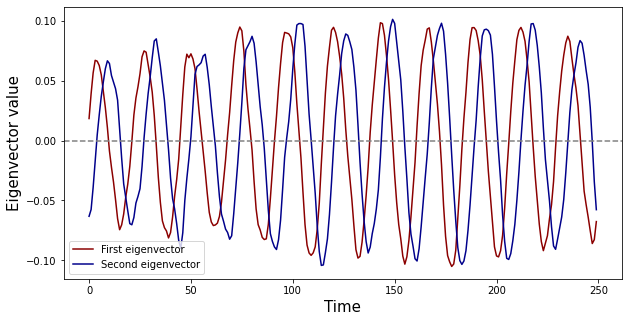

In [26]:
pb.subplots(figsize=(10, 5))
pb.plot(e_vects[:, 0], c='darkred', label='First eigenvector')
pb.plot(e_vects[:, 1], c='darkblue', label='Second eigenvector')
pb.legend()
pb.axhline(0, c='grey', ls='--')
pb.xlabel('Time', fontsize=15)
pb.ylabel('Eigenvector value', fontsize=15);

Thus I have computed $\Theta$ using only unique times series (use only dates 250, 500 and 750). 

This model gives an even worse train score $0.0285$.

In [27]:
data_class = DataClass()
x_df = data_class.xy.x_df.loc[pd.IndexSlice[::250, :], :]

#compute the covariance matrix between times
theta = x_df.corr().to_numpy()

# compute eigenvectors (given in the eigenvalues ascending order by eigh)
_, e_vects = np.linalg.eigh(theta)
e_vects = e_vects[:, ::-1]

# fill A
A = np.zeros((250, 10))
A[:, :10] = e_vects[:, :10]

#fit beta
beta = fit_beta(data_class.xy, A)

# compute score
metric(data_class.xy, A, beta)

0.0284643678

There are no more periods in the eigenvectors. The following figure represents the two first eigenvectors values.

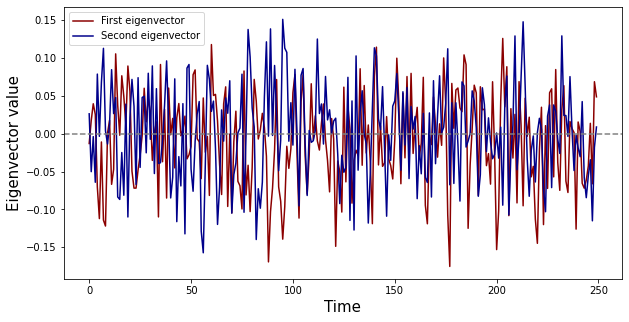

In [28]:
pb.subplots(figsize=(10, 5))
pb.plot(e_vects[:, 0], c='darkred', label='First eigenvector')
pb.plot(e_vects[:, 1], c='darkblue', label='Second eigenvector')
pb.legend()
pb.axhline(0, c='grey', ls='--')
pb.xlabel('Time', fontsize=15)
pb.ylabel('Eigenvector value', fontsize=15);